In [1]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import spikeextractors as se
import spiketoolkit as st
import spikewidgets as sw
import time
import numpy as np
import matplotlib.pylab as plt
import scipy.signal as ss
%matplotlib notebook

18:52:30 [I] klustakwik KlustaKwik2 version 0.2.6


### Create toy example dataset

In [3]:
recording, sorting = se.example_datasets.toy_example(num_channels=4, duration=30)

Assuming the `sorting` is the output of a spike sorter, the `postprocessing` module allows to extract all relevant information from the paired recording-sorting.

### Extracting waveforms

Waveforms are extracted with the `getUnitWaveforms` function by extracting snippets of the recordings when spikes are detected. When waveforms are extracted, the can be loaded in the `SortingExtractor` object as features. The ms before and after the spike event can be chosen. Waveforms are returned as a list of np.arrays (n_spikes, n_channels, n_points)

In [4]:
wf = st.postprocessing.getUnitWaveforms(recording, sorting, ms_before=1, ms_after=2, 
                                        save_as_features=True, verbose=True)

Waveform 1/10
Waveform 2/10
Waveform 3/10
Waveform 4/10
Waveform 5/10
Waveform 6/10
Waveform 7/10
Waveform 8/10
Waveform 9/10
Waveform 10/10


Now `waveforms` is a unit spike feature!

In [5]:
sorting.getUnitSpikeFeatureNames()
wf[0].shape

(69, 4, 90)

<IPython.core.display.Javascript object>


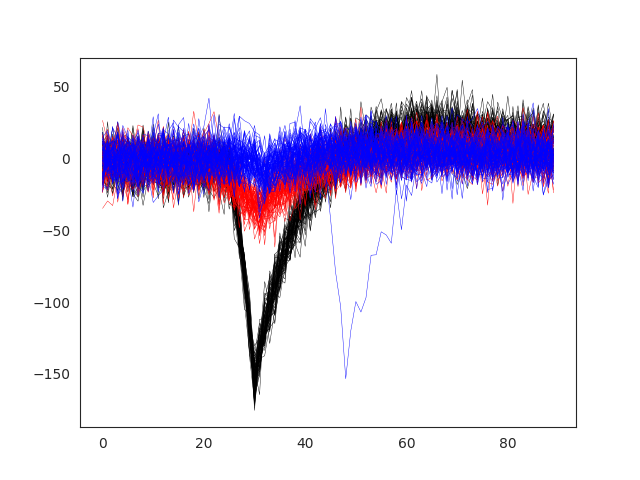

In [6]:
# plotting waveforms of units 0,1,2 on channel 0
plt.figure()
_ = plt.plot(wf[0][:, 0, :].T, color='k', lw=0.3)
_ = plt.plot(wf[1][:, 0, :].T, color='r', lw=0.3)
_ = plt.plot(wf[2][:, 0, :].T, color='b', lw=0.3)

If the a certain property (e.g. `group`) is present in the RecordingExtractor, the waveforms can be extracted only on the channels with that property using the `grouping_property` and `compute_property_from_recording` arguments. For example, if channel [0,1] are in group 0 and channel [2,3] are in group 2, then if the peak of the waveforms is in channel [0,1] it will be assigned to group 0 and will have 2 channels and the same for group 1.

In [7]:
channel_groups = [[0, 1], [2, 3]]
for ch in recording.getChannelIds():
    for gr, channel_group in enumerate(channel_groups):
        if ch in channel_group:
            recording.setChannelProperty(ch, 'group', gr)
print(recording.getChannelProperty(0, 'group'))

0


In [8]:
wf_by_group = st.postprocessing.getUnitWaveforms(recording, sorting, ms_before=1, ms_after=2, 
                                                 save_as_features=False, verbose=True,
                                                 grouping_property='group', compute_property_from_recording=True)

# now waveforms will only have 2 channels
print(wf_by_group[0].shape)

Waveforms by property:  group
Waveform 1/10
Waveform 2/10
Waveform 3/10
Waveform 4/10
Waveform 5/10
Waveform 6/10
Waveform 7/10
Waveform 8/10
Waveform 9/10
Waveform 10/10
(69, 2, 90)


### Templates (EAP)

Similarly to waveforms, templates - average waveforms - can be easily extracted using the `getUnitTemplates`. When spike trains have numerous spikes, you can set the `max_num_waveforms` to be extracted. If waveforms have already been computd and stored as `features`, those will be used. Templates can be saved as unit properties.

In [9]:
templates = st.postprocessing.getUnitTemplate(recording, sorting, max_num_waveforms=200,
                                              save_as_property=True, verbose=True)

Using 'waveforms' features


In [10]:
sorting.getUnitPropertyNames()

['template']

<IPython.core.display.Javascript object>


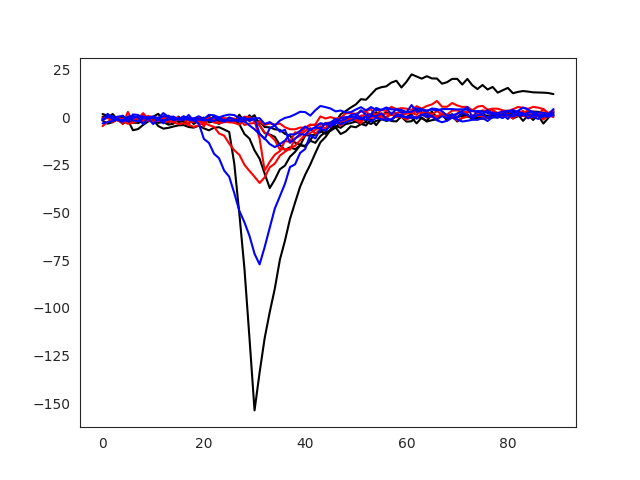

In [11]:
# plotting templates of units 0,1,2 on all four channels
plt.figure()
_ = plt.plot(templates[0].T, color='k')
_ = plt.plot(templates[1].T, color='r')
_ = plt.plot(templates[2].T, color='b')

### Maximum channel

In the same way, one can get the ecording channel with the maximum amplitude and save it as a property.

In [12]:
max_chan = st.postprocessing.getUnitMaxChannel(recording, sorting, save_as_property=True, verbose=True)
print(max_chan)

Using 'template' property
[0, 0, 1, 1, 1, 2, 2, 2, 3, 3]


In [13]:
sorting.getUnitPropertyNames()

['max_channel', 'template']

### PCA scores

For some applications, for example validating the spike sorting output, PCA scores can be computed.


In [14]:
pca_scores = st.postprocessing.computePCAScores(recording, sorting, n_comp=3, verbose=True)

for pc in pca_scores:
    print(pc.shape)

Using 'waveforms' features
Fitting PCA of 3 dimensions on 687 waveforms
(69, 3)
(69, 3)
(71, 3)
(70, 3)
(64, 3)
(73, 3)
(69, 3)
(70, 3)
(68, 3)
(64, 3)


<IPython.core.display.Javascript object>


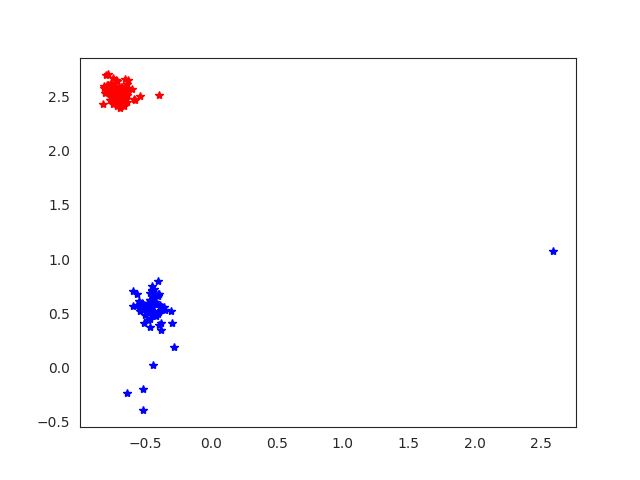

In [15]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(pca_scores[0][:,0], pca_scores[0][:,1], 'r*')
ax.plot(pca_scores[2][:,0], pca_scores[2][:,1], 'b*')

PCA scores can be also computed electrode-wise. In the previous example, PCA was applied to the concatenation of the waveforms over channels. 

In [16]:
pca_scores_by_electrode = st.postprocessing.computePCAScores(recording, sorting, n_comp=3, by_electrode=True)

for pc in pca_scores_by_electrode:
    print(pc.shape)

Fitting PCA of 3 dimensions on 2748 waveforms
(69, 4, 3)
(69, 4, 3)
(71, 4, 3)
(70, 4, 3)
(64, 4, 3)
(73, 4, 3)
(69, 4, 3)
(70, 4, 3)
(68, 4, 3)
(64, 4, 3)


In this case, as expected, 3 principal components are extracted for each electrode.

<IPython.core.display.Javascript object>


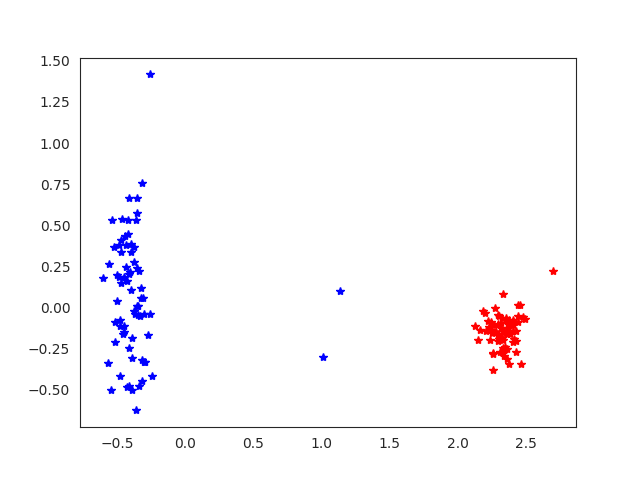

In [17]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(pca_scores_by_electrode[0][:, 0, 0], pca_scores_by_electrode[0][:, 1, 0], 'r*')
ax.plot(pca_scores_by_electrode[2][:, 0, 0], pca_scores_by_electrode[2][:, 1, 1], 'b*')

### Data curation using Phy

Finally, it is common to visualize and manually curate the data after spike sorting.
In order to do so, we interface wiht the Phy (https://phy-contrib.readthedocs.io/en/latest/template-gui/).

First, we need to export the data to the phy format:

In [18]:
st.postprocessing.exportToPhy(recording, sorting, output_folder='phy')

Changed number of PC to number of channels:  4
Fitting PCA of 4 dimensions on 2748 waveforms
Saved phy format to:  /home/alessiob/Documents/Codes/spike_sorting/spiketoolkit/examples/phy
Run:

phy template-gui  /home/alessiob/Documents/Codes/spike_sorting/spiketoolkit/examples/phy/params.py


In [20]:
!phy template-gui  /home/alessiob/Documents/Codes/spike_sorting/spiketoolkit/examples/phy/params.py --debug

18:52:47 [I] klustakwik KlustaKwik2 version 0.2.6
18:52:47 [D] __init__:48          Copy /home/alessiob/Documents/Codes/expipe/cinpla-base/src/phy-contrib/phycontrib/template/static/state.json to /home/alessiob/.phy/TemplateGUI/state.json
18:52:48 [D] model:395            Loading spike clusters.
18:52:48 [D] model:410            Loading templates.
18:52:48 [D] model:431            Loading the whitening matrix.
18:52:48 [D] model:435            Loading the inverse of the whitening matrix.
18:52:48 [D] model:101            Loading traces at `/home/alessiob/Documents/Codes/spike_sorting/spiketoolkit/examples/phy/recording.dat`.
18:52:48 [D] context:65           Initialize joblib cache dir at `/home/alessiob/Documents/Codes/spike_sorting/spiketoolkit/examples/phy/.phy`.
18:52:48 [D] config:46            Load config file `/home/alessiob/.phy/phy_config.py`.
18:52:48 [D] __init__:33          Loading 0 plugins.
18:52:48 [D] context:146          The file `/home/alessiob/Documents/Codes/spike_s

18:53:26 [D] base:94              Selecting [10] in <FeatureView (PyQt5) at 0x7fdcd00fd588>.
18:53:26 [D] base:94              Selecting [10] in <CorrelogramView (PyQt5) at 0x7fdcd0104550>.
/home/alessiob/Documents/Codes/expipe/cinpla-base/src/phy/phy/plot/visuals.py:520: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(_tesselate_histogram(row) for row in hist)
18:53:26 [D] qt:251               [JS:L47] Emit from JS global: select 4,5
18:53:26 [D] supervisor:636       Similar clusters selected: [4] (5)
18:53:26 [D] supervisor:179       Log SimilarityView select ([4],) ([[4], 5])
18:53:26 [D] supervisor:179       Log SimilarityView select ([4],) ([[4], 5])
18:53:26 [D] supervisor:114       No method _after_select
18:53:26 [D] base:94              Selecting [10, 4] in <WaveformView (PyQt5) at 0x7fdd000889e8

In this case, in phy, we manually merged to units. We can load back the curated data using the `PhysortingExtractor`:

In [22]:
sorting_curated = se.PhySortingExtractor('phy/')

In [25]:
print('Before curation: ', len(sorting.getUnitIds()))
print('After curation: ', len(sorting_curated.getUnitIds()))

Before curation:  10
After curation:  9
